In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

pip install "ipython[notebook]" --upgrade

     |████████████████████████████████| 792 kB 4.1 MB/s            
  Attempting uninstall: ipython
    Found existing installation: ipython 7.29.0
    Uninstalling ipython-7.29.0:
      Successfully uninstalled ipython-7.29.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.4 requires google-cloud-bigquery-storage, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# for data visulaization 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
# for data preprocessing 
from pathlib import Path 
from sklearn.model_selection import train_test_split
# for model building 
import tensorflow as tf 
# for evalution of the model 
from sklearn.metrics import confusion_matrix, classification_report


here we are generating data frame to avoid dealing with the data set directory and we can mannipulate the data set as per the requirement 
there are two ways to perform the below step 
1. flow from directory --> this case we will use when we have a directory in which we have test and train data available seperately 
2. flow from data frame --> this case we will use when we are having data set stored in the directory but test and train data are not seperated and using this concept we are creating directory by passing the path of original data set to create the new directory and from there we generate data frame and split is as per our convinence  

In [4]:
positive_data = Path("../input/surface-crack-detection/Positive")
negative_data = Path("../input/surface-crack-detection/Negative")


here we are trying to generate data frame using user define function 

In [5]:
def generate_df(image_data,label):
    dataset_path = pd.Series(list(image_data.glob(r'*.jpg')), name = 'dataset_path').astype(str)
    labels = pd.Series(label , name = 'label', index = dataset_path.index)
    df = pd.concat([dataset_path,labels],axis = 1 )
    return df 

In [6]:
positive_df = generate_df(positive_data, label = 'POSITIVE')
negative_df =  generate_df(negative_data, label = 'NEGATIVE')
All_df = pd.concat([positive_df,negative_df],axis = 0 ).sample(frac=1.0,random_state=1).reset_index(drop=True)
All_df

,dataset_path,label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


after performing the above step we will store the generated value in a variable. here we are provide label as positive and negative because later we are going to use tensor flow from data frame there it will be expecting string value instead of int so to avoid error over there we are using. in the above piece of code we are concating the positive and negative data frame one over other and as we can see there is two error all positive class is displayed first and later it is displaying negative class also there is error in the index part so to address those issue we have to shuffle the data set and also we have to rearrange the entire data set after concatenation and we have to reset the index and we have to put drop=True to avoid creation of new col

once we are ready with our postive and negative data set next step is we have to spilt our data into traing and testing phase and we are considering only 6k data set for building our model and we have split data into 70-30 ratio and we are shuffling it

# Train_test_split

In [7]:
train_df, test_df = train_test_split(All_df, train_size = .7, shuffle = 'True', random_state = 42 )

In [8]:
train_df.shape

(28000, 2)

In [9]:
test_df.shape

(12000, 2)

In [10]:
train_data_set = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = .2 )
# here we have used validation split because we are trying to divide our training data set into traning(80%) and validation(20%) 
test_data_set = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
train_data = train_data_set.flow_from_dataframe(train_df,x_col = 'dataset_path',y_col = 'label',
                                               target_size= (120,120),
                                               color_mode = 'rgb',
                                               class_mode = 'binary',
                                               batch_size = 32,
                                               shuffle = 'True',
                                               seed = 42,
                                               subset = 'training')
val_data = train_data_set.flow_from_dataframe(train_df, x_col = 'dataset_path',y_col = 'label',
                                               target_size= (120,120),
                                               color_mode = 'rgb',
                                               class_mode = 'binary',
                                               batch_size = 32,
                                               shuffle = 'True',
                                               seed = 42,
                                               subset = 'validation')
test_data = test_data_set.flow_from_dataframe(test_df, x_col = 'dataset_path',y_col = 'label',
                                               target_size= (120,120),
                                               color_mode = 'rgb',
                                               class_mode = 'binary',
                                               batch_size = 32,
                                               shuffle = 'False',
                                               seed = 42,
                                               )


Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


# traing the model 
using convolution layer we are trying to extract feature from the given image 

In [11]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters = 16,kernel_size=(3,3),activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters = 32,kernel_size=(3,3),activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
# siince the output of convolutional and maxpooling layer will give 2d output so we have to convert it to 1d so we have used GlobalAveragePooling2D
# we can also use flatten image to bring 2d to lower dimension 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
              metrics = ['accuracy']
             )
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

2022-01-18 05:36:29.043698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 05:36:29.044752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 05:36:29.045382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 05:36:29.046234: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
history = model.fit(
train_data,
validation_data = val_data,
epochs = 10,
callbacks = [tf.keras.callbacks.EarlyStopping(
monitor = 'val_loss',
patience =3,
restore_best_weights = True)])

2022-01-18 05:36:31.644367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-18 05:36:33.120217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


700/700 [==============================] - 118s 160ms/step - loss: 0.4543 - accuracy: 0.8073 - val_loss: 0.2244 - val_accuracy: 0.9425
Epoch 2/10
700/700 [==============================] - 46s 66ms/step - loss: 0.1483 - accuracy: 0.9606 - val_loss: 0.1250 - val_accuracy: 0.9643
Epoch 3/10
700/700 [==============================] - 47s 66ms/step - loss: 0.0984 - accuracy: 0.9708 - val_loss: 0.0947 - val_accuracy: 0.9734
Epoch 4/10
700/700 [==============================] - 46s 66ms/step - loss: 0.0816 - accuracy: 0.9754 - val_loss: 0.0846 - val_accuracy: 0.9782
Epoch 5/10
700/700 [==============================] - 44s 63ms/step - loss: 0.0757 - accuracy: 0.9768 - val_loss: 0.0763 - val_accuracy: 0.9761
Epoch 6/10
700/700 [==============================] - 45s 64ms/step - loss: 0.0695 - accuracy: 0.9786 - val_loss: 0.0676 - val_accuracy: 0.9800
Epoch 7/10
700/700 [==============================] - 44s 63ms/step - loss: 0.0644 - accuracy: 0.9796 - val_loss: 0.0782 - val_accuracy: 0.9754
E

# visualization of training and validation loss over time 

In [13]:
fig = px.line(
history.history,
y=['loss','val_loss'],
labels= {'index':'epoch','value':'loss'},
title = "training and validation loss ")
fig.show()


In [14]:
fig = px.line(
history.history,
y = ['accuracy','val_accuracy'],
labels = {'index':'epoch','value':'accuracy '},
title = ' training and validation accuracy ')
fig.show()

# Result 

In [15]:
def evaluate_model (model,test_data):
    results = model.evaluate (test_data,verbose=0)
    loss = results[0]
    accuracy = results[1]
    print("test loss: {:.5f}".format(loss))
    print("test accuracy: {:.2f}%".format(accuracy*100))
           

In [16]:
evaluate_model(model,test_data)

test loss: 0.05452
test accuracy: 98.18%


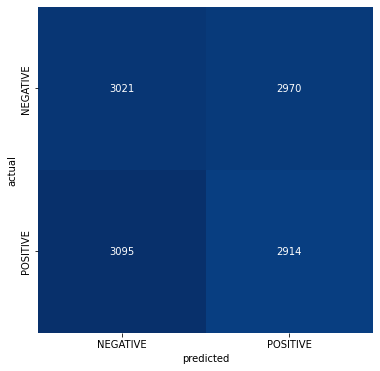

In [17]:
y_pred = np.squeeze((model.predict(test_data)>=0.5).astype(np.int))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report (test_data.labels, y_pred, target_names = ["NEGATIVE","POSITIVE"])
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
plt.xticks(ticks=np.arange(2)+.5,labels = ['NEGATIVE','POSITIVE'])
plt.yticks(ticks=np.arange(2)+.5,labels = ['NEGATIVE','POSITIVE'])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [18]:
print("classification Report:\n---------------------------------------------------------------------\n",clr)

classification Report:
---------------------------------------------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.49      0.50      0.50      5991
    POSITIVE       0.50      0.48      0.49      6009

    accuracy                           0.49     12000
   macro avg       0.49      0.49      0.49     12000
weighted avg       0.49      0.49      0.49     12000



now once 